## **Ejercicio 2:** Inpainting con U-Net sobre Oxford-IIIT Pet + Máscaras irregulares
**Descripción:**

Inpainting es una técnica de visión por computador que consiste en reconstruir o completar regiones faltantes de una imagen de manera que el resultado final luzca lo más natural y coherente posible. Se utiliza en aplicaciones como la restauración de imágenes dañadas, eliminación de objetos, edición de fotografías y generación de contenido.

El objetivo es entrenar desde cero una U-Net para rellenar las regiones faltantes (inpainting).

![Fig I](https://drive.google.com/uc?export=view&id=1HZIAqvtlHsd5LfFtW4felRTXMNQngyAo)

Para esto deberás preparar el dataset de entrenamiento y entrenar la red neuronal (UNet)- Partiremos del conjunto pet_dataset/images (665 imágenes RGB ,jpg de 256 × 256 px) y de irregular_masks (3122 máscaras binarias .png de 224 × 224 px, blanco = conservar, negro = hueco del inpainting). Las máscaras irregulares se pueden usar con cualquier imagen RGB para generar el dato de entrada.

In [4]:
# IDs de los archivos en Google Drive
masks_id   = "1Bk-96U0SrGuw7qFo9v1I0-1e08OUlMtD"   # irregular_masks.zip
pets_id    = "1oMznBTR_0ROpZzC4j08xDenoG7ARQ5eN"   # pet_dataset_lab4.zip

# 3Descarga de los archivos .zip
!gdown --id $masks_id -O irregular_masks.zip
!gdown --id $pets_id  -O pet_dataset_lab4.zip

# Descompresión de los contenidos
!unzip -q irregular_masks.zip
!unzip -q pet_dataset_lab4.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Bk-96U0SrGuw7qFo9v1I0-1e08OUlMtD
To: /content/irregular_masks.zip
100% 7.50M/7.50M [00:00<00:00, 17.4MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oMznBTR_0ROpZzC4j08xDenoG7ARQ5eN
To: /content/pet_dataset_lab4.zip
100% 20.7M/20.7M [00:00<00:00, 26.8MB/s]


### **1.- Preparación del dataset**

*   Deberán crear una clase que lea la imagen RGB (target) y que seleccione una máscara al azar (noten que estas tienen una dimensión distinta a la RGB) y que devuelva la imagen con huecos.
*   La clase debería devolver imagen_con_huecos e imagen_completa y si sirve, también la máscara



In [5]:
class InpaintingDataset(Dataset):
    """
    Devuelve:
        x  : imagen RGB con huecos (tensor C×H×W, normalizado [0,1])
        y  : imagen RGB original completa (tensor C×H×W, [0,1])
        m  : máscara binaria (tensor 1×H×W, 1 = conservar, 0 = hueco)
    """
    def __init__(self, img_dir: str, mask_dir: str, img_size: int = 256):
        self.img_paths  = [os.path.join(img_dir, f)  for f in os.listdir(img_dir)  if f.endswith(".jpg")]
        self.mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")]
        self.img_size = img_size

    def __len__(self) -> int:
        return len(self.img_paths)

    def _load_img(self, path: str) -> torch.Tensor:
        img = Image.open(path).convert("RGB")
        img = TF.resize(img, self.img_size, interpolation=Image.BILINEAR)
        return TF.to_tensor(img)

    def _load_mask(self, path: str) -> torch.Tensor:
        mask = Image.open(path).convert("L")
        mask = TF.resize(mask, self.img_size, interpolation=Image.NEAREST)
        mask = TF.to_tensor(mask)                     # [0,1]
        mask = (mask > 0.5).float()                   # binariza
        return mask

    def __getitem__(self, idx: int):
        y = self._load_img(self.img_paths[idx])       # imagen completa
        m = self._load_mask(random.choice(self.mask_paths))
        x = y * m                                     # aplica huecos
        return x, y, m

### **2.- Visualización de datos**:
* Debe mostrarse la entrada a la UNet (imagen con huecos), máscara (invertida) y target de la UNet (Ground-Truth)



In [6]:
dataset_raw = InpaintingDataset(
    img_dir  = "pet_dataset/images",
    mask_dir = "irregular_masks",
    img_size = 256)

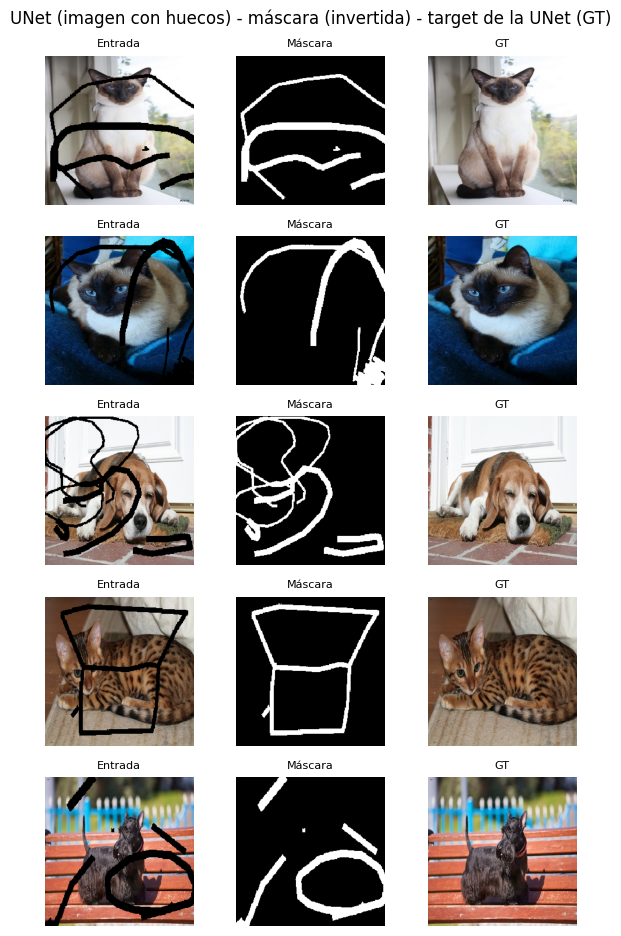

In [7]:
K = 5 # cantidad de imagenes loader
samples = [dataset_raw[random.randrange(len(dataset_raw))] for _ in range(K)]  # (x, y, m)

fig, axes = plt.subplots(K, 3, figsize=(6, 1.9*K), squeeze=False)
fig.suptitle("UNet (imagen con huecos) - máscara (invertida) - target de la UNet (GT)", fontsize=12)

for i, (x, y, m) in enumerate(samples):
    # Entrada (imagen con huecos)
    axes[i, 0].imshow(TF.to_pil_image(x))
    axes[i, 0].set_title("Entrada", fontsize=8)

    # Máscara invertida (hueco en blanco)
    axes[i, 1].imshow(TF.to_pil_image(1.0 - m), cmap="gray")
    axes[i, 1].set_title("Máscara", fontsize=8)

    # Ground-Truth (imagen completa)
    axes[i, 2].imshow(TF.to_pil_image(y))
    axes[i, 2].set_title("GT", fontsize=8)

    for ax in axes[i]:
        ax.axis("off")
plt.tight_layout()
plt.show()

### **3.- Diseño de la U-Net:**
* Puede ser una UNet simple o variaciones de ella.

In [9]:
class MaskConcatWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        x, y, m = self.base_ds[idx]           # x = RGB con huecos, m = binaria
        return x, y                           # máscara ya no es necesaria

wrapped_ds = MaskConcatWrapper(dataset_raw)

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, base_c=64):
        super().__init__()
        # Encoder
        self.d1 = DoubleConv(c_in, base_c)
        self.d2 = DoubleConv(base_c, base_c*2)
        self.d3 = DoubleConv(base_c*2, base_c*4)
        self.d4 = DoubleConv(base_c*4, base_c*8)
        self.maxp = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = DoubleConv(base_c*8, base_c*16)
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_c*16, base_c*8, 2, 2)
        self.u4  = DoubleConv(base_c*16, base_c*8)
        self.up3 = nn.ConvTranspose2d(base_c*8,  base_c*4, 2, 2)
        self.u3  = DoubleConv(base_c*8,  base_c*4)
        self.up2 = nn.ConvTranspose2d(base_c*4,  base_c*2, 2, 2)
        self.u2  = DoubleConv(base_c*4,  base_c*2)
        self.up1 = nn.ConvTranspose2d(base_c*2, base_c,   2, 2)
        self.u1  = DoubleConv(base_c*2, base_c)
        # Salida
        self.out_conv = nn.Conv2d(base_c, c_out, 1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.maxp(x1))
        x3 = self.d3(self.maxp(x2))
        x4 = self.d4(self.maxp(x3))
        xb = self.bottleneck(self.maxp(x4))
        x  = self.up4(xb); x = self.u4(torch.cat([x4, x], 1))
        x  = self.up3(x ); x = self.u3(torch.cat([x3, x], 1))
        x  = self.up2(x ); x = self.u2(torch.cat([x2, x], 1))
        x  = self.up1(x ); x = self.u1(torch.cat([x1, x], 1))
        return torch.sigmoid(self.out_conv(x))

model = UNet().to(device)
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

Parámetros totales: 31.04 M


### **4.- Entrenamiento y evaluación:**
* Máximo por 50 épocas. Toma en cuenta el tiempo de entrenamiento y los recursos limitados.


In [11]:
# División del conjutno train y val
train_len = int(0.85 * len(wrapped_ds))
val_len   = len(wrapped_ds) - train_len
train_ds, val_ds = torch.utils.data.random_split(
    wrapped_ds, [train_len, val_len],
    generator=torch.Generator().manual_seed(42))


train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

xb, yb = next(iter(train_dl))
print("Input (RGB+mask) :", xb.shape)   # (B, 3, 256, 256)
print("Target RGB       :", yb.shape)   # (B, 3, 256, 256)

Input (RGB+mask) : torch.Size([16, 3, 256, 256])
Target RGB       : torch.Size([16, 3, 256, 256])


In [14]:
# Configuración de entrenamiento
criterion = nn.L1Loss()                  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS    = 50
best_psnr = 0

def psnr_batch(pred, target, eps=1e-8):
    mse = torch.mean((pred - target) ** 2, dim=[1,2,3]) + eps
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [16]:
for epoch in trange(1, EPOCHS+1, desc="Entrenando"):
    # —— entrenamiento
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    # —— validación
    model.eval(); val_psnr = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred   = model(xb)
            val_psnr.extend(psnr_batch(pred, yb).cpu().tolist())
    mean_psnr = np.mean(val_psnr)
    print(f"Época {epoch:02d} | PSNR val = {mean_psnr:.2f} dB")

    # —— guardado de mejor modelo
    if mean_psnr > best_psnr:
        best_psnr = mean_psnr
        torch.save(model.state_dict(), "unet_inpainting_best.pth")

print(f"Mejor PSNR validación: {best_psnr:.2f} dB")

Entrenando:   0%|          | 0/50 [00:00<?, ?it/s]

Época 01 | PSNR val = 15.75 dB


Entrenando:   2%|▏         | 1/50 [00:28<23:00, 28.17s/it]

Época 02 | PSNR val = 21.95 dB


Entrenando:   4%|▍         | 2/50 [00:56<22:42, 28.40s/it]

Época 03 | PSNR val = 22.25 dB


Entrenando:   8%|▊         | 4/50 [01:53<21:39, 28.24s/it]

Época 04 | PSNR val = 19.27 dB
Época 05 | PSNR val = 24.48 dB


Entrenando:  12%|█▏        | 6/50 [02:49<20:46, 28.32s/it]

Época 06 | PSNR val = 24.27 dB
Época 07 | PSNR val = 25.19 dB


Entrenando:  16%|█▌        | 8/50 [03:46<19:48, 28.29s/it]

Época 08 | PSNR val = 24.71 dB


Entrenando:  18%|█▊        | 9/50 [04:14<19:20, 28.31s/it]

Época 09 | PSNR val = 21.44 dB
Época 10 | PSNR val = 25.30 dB


Entrenando:  22%|██▏       | 11/50 [05:11<18:23, 28.29s/it]

Época 11 | PSNR val = 24.76 dB


Entrenando:  24%|██▍       | 12/50 [05:39<17:53, 28.24s/it]

Época 12 | PSNR val = 22.49 dB


Entrenando:  26%|██▌       | 13/50 [06:07<17:26, 28.29s/it]

Época 13 | PSNR val = 24.13 dB


Entrenando:  28%|██▊       | 14/50 [06:36<16:57, 28.26s/it]

Época 14 | PSNR val = 24.13 dB


Entrenando:  30%|███       | 15/50 [07:04<16:28, 28.24s/it]

Época 15 | PSNR val = 25.12 dB
Época 16 | PSNR val = 25.31 dB


Entrenando:  34%|███▍      | 17/50 [08:00<15:31, 28.22s/it]

Época 17 | PSNR val = 22.63 dB
Época 18 | PSNR val = 26.12 dB


Entrenando:  38%|███▊      | 19/50 [08:57<14:37, 28.31s/it]

Época 19 | PSNR val = 25.37 dB


Entrenando:  40%|████      | 20/50 [09:25<14:07, 28.25s/it]

Época 20 | PSNR val = 23.96 dB


Entrenando:  42%|████▏     | 21/50 [09:53<13:38, 28.22s/it]

Época 21 | PSNR val = 18.89 dB


Entrenando:  44%|████▍     | 22/50 [10:22<13:10, 28.22s/it]

Época 22 | PSNR val = 22.23 dB
Época 23 | PSNR val = 27.44 dB


Entrenando:  48%|████▊     | 24/50 [11:18<12:14, 28.24s/it]

Época 24 | PSNR val = 25.71 dB


Entrenando:  50%|█████     | 25/50 [11:46<11:46, 28.25s/it]

Época 25 | PSNR val = 25.68 dB
Época 26 | PSNR val = 27.50 dB


Entrenando:  54%|█████▍    | 27/50 [12:43<10:49, 28.24s/it]

Época 27 | PSNR val = 24.18 dB


Entrenando:  56%|█████▌    | 28/50 [13:11<10:21, 28.26s/it]

Época 28 | PSNR val = 25.07 dB


Entrenando:  58%|█████▊    | 29/50 [13:39<09:52, 28.22s/it]

Época 29 | PSNR val = 25.84 dB


Entrenando:  60%|██████    | 30/50 [14:08<09:23, 28.18s/it]

Época 30 | PSNR val = 26.61 dB
Época 31 | PSNR val = 27.90 dB


Entrenando:  64%|██████▍   | 32/50 [15:04<08:29, 28.30s/it]

Época 32 | PSNR val = 26.07 dB


Entrenando:  66%|██████▌   | 33/50 [15:33<08:00, 28.25s/it]

Época 33 | PSNR val = 25.35 dB


Entrenando:  68%|██████▊   | 34/50 [16:01<07:31, 28.22s/it]

Época 34 | PSNR val = 26.69 dB


Entrenando:  70%|███████   | 35/50 [16:29<07:03, 28.23s/it]

Época 35 | PSNR val = 24.58 dB


Entrenando:  72%|███████▏  | 36/50 [16:57<06:34, 28.19s/it]

Época 36 | PSNR val = 23.91 dB


Entrenando:  74%|███████▍  | 37/50 [17:25<06:06, 28.18s/it]

Época 37 | PSNR val = 27.73 dB


Entrenando:  76%|███████▌  | 38/50 [17:53<05:38, 28.19s/it]

Época 38 | PSNR val = 20.89 dB


Entrenando:  78%|███████▊  | 39/50 [18:22<05:09, 28.17s/it]

Época 39 | PSNR val = 27.77 dB


Entrenando:  80%|████████  | 40/50 [18:50<04:41, 28.15s/it]

Época 40 | PSNR val = 26.72 dB


Entrenando:  82%|████████▏ | 41/50 [19:18<04:13, 28.16s/it]

Época 41 | PSNR val = 23.41 dB


Entrenando:  84%|████████▍ | 42/50 [19:46<03:45, 28.16s/it]

Época 42 | PSNR val = 24.55 dB


Entrenando:  86%|████████▌ | 43/50 [20:14<03:17, 28.17s/it]

Época 43 | PSNR val = 22.89 dB


Entrenando:  88%|████████▊ | 44/50 [20:42<02:49, 28.19s/it]

Época 44 | PSNR val = 24.59 dB


Entrenando:  90%|█████████ | 45/50 [21:11<02:20, 28.18s/it]

Época 45 | PSNR val = 27.64 dB


Entrenando:  92%|█████████▏| 46/50 [21:39<01:52, 28.15s/it]

Época 46 | PSNR val = 27.46 dB


Entrenando:  94%|█████████▍| 47/50 [22:07<01:24, 28.16s/it]

Época 47 | PSNR val = 22.28 dB


Entrenando:  96%|█████████▌| 48/50 [22:35<00:56, 28.17s/it]

Época 48 | PSNR val = 26.87 dB


Entrenando:  98%|█████████▊| 49/50 [23:03<00:28, 28.17s/it]

Época 49 | PSNR val = 24.69 dB


Entrenando: 100%|██████████| 50/50 [23:31<00:00, 28.24s/it]

Época 50 | PSNR val = 23.52 dB
Mejor PSNR validación: 27.90 dB


In [23]:
# Cargar el mejor modelo
model.load_state_dict(torch.load("unet_inpainting_best.pth", map_location=device))
model.eval(); print("Pesos mejor validados cargados.")

# Métrica PSNR
@torch.no_grad()
def psnr_batch(pred, target, eps=1e-8):
    mse = torch.mean((pred - target) ** 2, dim=[1,2,3]) + eps
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# Evaluación sobre todo el split val
all_scores, all_triplets = [], []          # (psnr, x_in, pred, y_gt)
with torch.no_grad():
    for x_in, y_gt in val_dl:
        pred = model(x_in.to(device)).cpu()
        scores = psnr_batch(pred, y_gt).tolist()
        all_scores.extend(scores)
        for s, a, b, c in zip(scores, x_in, pred, y_gt):
            all_triplets.append((s, a, b, c))


mean_psnr = np.mean(all_scores)
median_psnr = np.median(all_scores)
print(f"PSNR validación  |  media = {mean_psnr:.2f} dB   ·   mediana = {median_psnr:.2f} dB")

Pesos mejor validados cargados.
PSNR validación  |  media = 27.89 dB   ·   mediana = 28.02 dB


### **5.- Visualización de resultados y métricas:**
* Visualización donde se muestre un buen rellenado de huecos.
* Pueden medir la calidad del rellenado usando PSNR (PSNR de 30 es bueno)


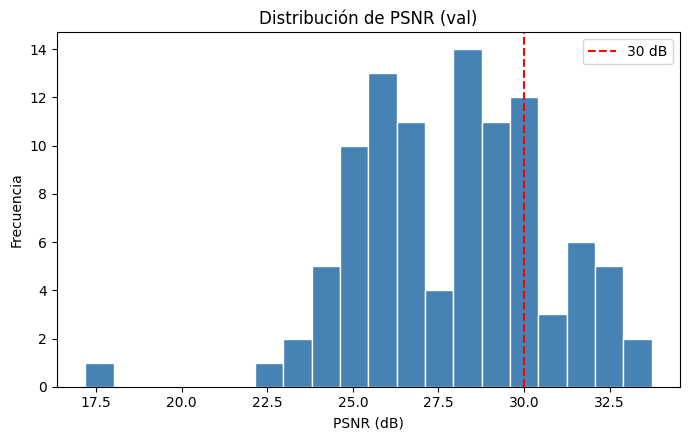

In [27]:
#  Visualización de resultados
# Histograma rápido de PSNR
plt.figure(figsize=(7,4.5))
plt.hist(all_scores, bins=20, color="steelblue", edgecolor="white")
plt.axvline(30, color="red", ls="--", label="30 dB")
plt.title("Distribución de PSNR (val)")
plt.xlabel("PSNR (dB)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

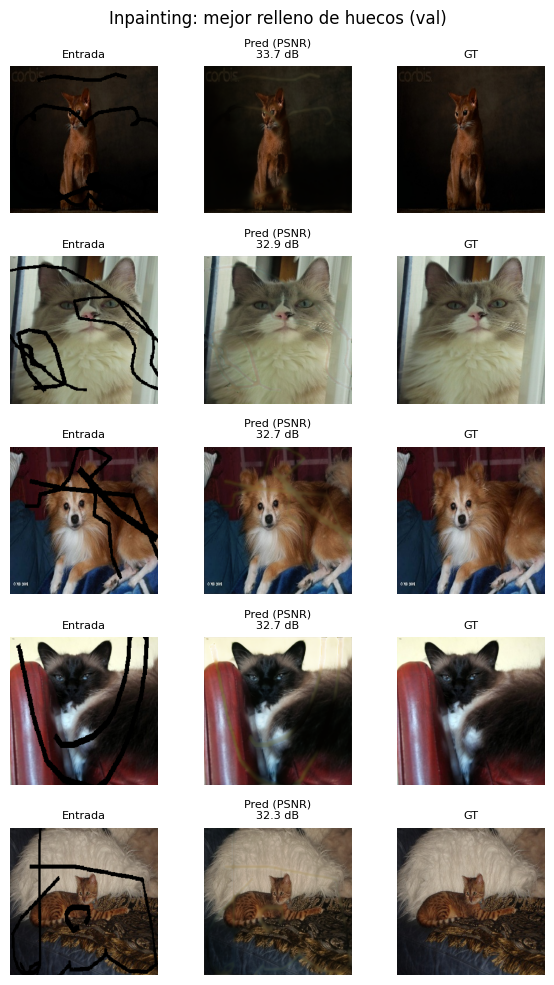

In [31]:
# Grid Entrada · Pred · GT para los 4 mejores ejemplos
all_triplets.sort(key=lambda t: t[0], reverse=True)   # ord. descendente por PSNR
K = 5
fig, ax = plt.subplots(K, 3, figsize=(6, 2*K))
titles = ["Entrada", "Pred (PSNR)", "GT"]

for i, (score, x_in, pred, y_gt) in enumerate(all_triplets[:K]):
    imgs = [x_in, pred.clamp(0,1), y_gt]
    for j in range(3):
        ax[i,j].imshow(to_pil_image(imgs[j]))
        t = f"{titles[j]}\n{score:.1f} dB" if j==1 else titles[j]
        ax[i,j].set_title(t, fontsize=8)
        ax[i,j].axis("off")

fig.suptitle("Inpainting: mejor relleno de huecos (val)")
plt.tight_layout()
plt.show()